# ロジスティック回帰モデルによる値動きの予測

In [1]:
# ライブラリのインポート
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
from datetime import date, datetime, timedelta
import talib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
#warnings.simplefilter(action="ignore", category=FutureWarning)

## オシレーター指標関数の定義

In [2]:
# function Klinger Volume Oscillator (KVO)
def klinger_volume_oscillator(df, short_period=34, long_period=55, signal_period=13):
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['VolumeForce'] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], -df['Volume'])
    df['KVO'] = (df['VolumeForce'].rolling(window=short_period).sum() -
                 df['VolumeForce'].rolling(window=long_period).sum())
    df['KVO_Signal'] = df['KVO'].rolling(window=signal_period).mean()
    return df['KVO'], df['KVO_Signal']

# function Elder's Force Index (EFI)
def elder_force_index(df, period=2):
    df['EFI'] = (df['Close'] - df['Close'].shift(1)) * df['Volume']
    df['EFI_Smoothed'] = df['EFI'].rolling(window=period).mean()
    return df['EFI_Smoothed']

# function true_strength_index (TSI)
def true_strength_index(df, short_period=13, long_period=25):
    df['Change'] = df['Close'] - df['Close'].shift(1)
    df['Smoothed1'] = df['Change'].ewm(span=short_period, adjust=False).mean()
    df['Smoothed2'] = df['Smoothed1'].ewm(span=long_period, adjust=False).mean()
    df['AbsChange'] = abs(df['Change'])
    df['AbsSmoothed1'] = df['AbsChange'].ewm(span=short_period, adjust=False).mean()
    df['AbsSmoothed2'] = df['AbsSmoothed1'].ewm(span=long_period, adjust=False).mean()
    df['TSI'] = (df['Smoothed2'] / df['AbsSmoothed2']) * 100
    return df['TSI']

# オーサムオシレーター
def awesome_oscillator(df, wshort=5, wlong=34):
  # 中値
  df['med'] = (df['High']+df['Low']) / 2
  # オーサムオシレーター
  df['ao'] = df['med'].rolling(wshort).mean() - df['med'].rolling(wlong).mean()
  # 加速減速オシレーター
  df['ado'] = df['ao'] - df['ao'].rolling(wshort).mean()
  return df['ao'], df['ado']

# Choppiness index
def choppiness_index(data, period=14):
    # Calculate the True Range
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    # Sum of the True Range over the given period
    atr = true_range.rolling(window=period).sum()
    # Calculate the difference between the highest high and lowest low over the period
    max_high = data['High'].rolling(window=period).max()
    min_low = data['Low'].rolling(window=period).min()
    # Calculate the Choppiness Index
    chop = 100 * np.log10(atr / (max_high - min_low)) / np.log10(period)
    return chop

## パフォーマンス評価関数の定義

In [3]:
def evaluate_performance(data):
    cumulative_return = data['Portfolio_Value'].iloc[-1] / data['Portfolio_Value'].iloc[0] - 1
    volatility = data['Strategy_Returns'].std() * (252**0.5)
    sharpe_ratio = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()) * (252**0.5)
    return {
        "Cumulative Return": cumulative_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio
    }

## 株価データの読み込み

In [4]:
# Download data
ticker = '8306.T'
end_date = datetime.today()
start_date = end_date - timedelta(days=730)
data = yf.download(ticker, start_date, end_date)
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
data.index = pd.to_datetime(data.index)

[*********************100%***********************]  1 of 1 completed


In [5]:
data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-02-03,1926.0,1951.0,1919.0,1946.0,66155400
2025-02-04,1941.5,1954.0,1932.0,1940.0,54245400
2025-02-05,1930.0,1971.0,1920.0,1950.0,68815300
2025-02-06,1912.5,1943.0,1903.5,1940.0,53281200
2025-02-07,1911.0,1922.0,1893.5,1917.0,33481300


## 特徴量（説明変数）の生成

In [6]:
# Create features based on prices 
data['SMA50'] = data['Close'].rolling(window=50).mean() 
data['SMA200'] = data['Close'].rolling(window=200).mean() 
data['Volatility'] = data['Close'].rolling(window=20).std() 
data['Daily Return'] = data['Close'].pct_change() 
# 各種指標値の計算
data['SMA_short'] = talib.SMA(data['Close'], timeperiod=5)
data['SMA_long'] = talib.SMA(data['Close'], timeperiod=25)
data['CMO'] = talib.CMO(data['Close'], timeperiod=14)
data['KVO'], data['KVO_Signal'] = klinger_volume_oscillator(data)
data['EFI'] = elder_force_index(data)
data['TSI'] = true_strength_index(data)
data['ARO'] = talib.AROONOSC(data['High'], data['Low'], timeperiod=25)
data['MACD'], data['MACD_signal'], data['MACD_hist'] = talib.MACD(data['Close'], \
        fastperiod=12, slowperiod=26, signalperiod=9)
data['AO'], data['ADO'] = awesome_oscillator(data)
data['TRIX'] = talib.TRIX(data['Close'], timeperiod=9)
data["RSI"] = talib.RSI(data["Close"], timeperiod=14)
data["ADX"] = talib.ADX(data["High"], data["Low"], data["Close"], timeperiod=14)
data["CCI"] = talib.CCI(data["High"], data["Low"], data["Close"], timeperiod=14)
data["slowk"], data["slowd"] = talib.STOCH(data["High"], data["Low"], data["Close"], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data["fastk"], data["fastd"] = talib.STOCHF(data["High"], data["Low"], data["Close"], fastk_period=5, fastd_period=3, fastd_matype=0)
data["WILLR"] = talib.WILLR(data["High"], data["Low"], data["Close"], timeperiod=14)
data["OBV"] = talib.OBV(data["Close"], data["Volume"])
data["upperband"], data["middleband"], data["lowerband"] = talib.BBANDS(data["Close"], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
data['bol_buy'] = data['lowerband'] - data['Close']
data["SAR"] = talib.SAR(data["High"], data["Low"], acceleration=0, maximum=0)
data['CHOP'] = choppiness_index(data)
data['candle'] = talib.CDLENGULFING(data['Open'],data['High'],data['Low'],data['Close'])

## 目的変数の生成

In [7]:
# Remove NaN rows 
data = data.dropna().reset_index()
# Create binary target label for prediction
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

## 特徴量の指定とモデルの初期設定

In [8]:
# Select features and target
features = ['MACD','EFI','RSI','fastd','OBV']
#features = ['SMA50','SMA200','Volatility','Daily Return']
X = data[features]
y = data['Target']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## モデルの生成と学習

In [9]:
# Create and train the model
#model = LogisticRegression()
model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
#model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0)
#model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0)
model.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [10]:
# Evaluate the model
y_pred = model.predict(X_test)  
print("Accuracy:", accuracy_score(y_test, y_pred))  
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.576271186440678
Confusion Matrix:
 [[10 21]
 [ 4 24]]


In [11]:
new_data = X.tail(1)
prediction = model.predict(new_data)  
print("Prediction:", prediction)

Prediction: [0]


In [12]:
# Get probability predictions
probabilities = model.predict_proba(new_data)
# Print the first few probability predictions
print(probabilities)

[[0.54110731 0.45889269]]


## ポジションとリターン

In [13]:
# Add predictions to the test DataFrame
data['Predicted_Signal'] = model.predict(X) * 2 - 1
# Create the trading position: 1 for buy, -1 for sell
data['Position'] = data['Predicted_Signal'].shift()
# Calculate strategy returns
data['Strategy_Returns'] = data['Position'] * data['Daily Return']
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod() - 1
data['Cumulative_Market_Returns'] = (1 + data['Daily Return']).cumprod() - 1

## バックテスト

In [14]:
initial_balance = 10000
df = data.copy()
df['Portfolio_Value'] = (1 + df['Strategy_Returns']).cumprod() * initial_balance
df.at[df.index[0], 'Portfolio_Value'] = initial_balance
performance = evaluate_performance(df)
print(ticker[0]  + '  Performance')
print(performance)

8  Performance
{'Cumulative Return': 1.448248294213783, 'Volatility': 0.34051091470641426, 'Sharpe Ratio': 2.461688528526214}


## パフォーマンスの図示

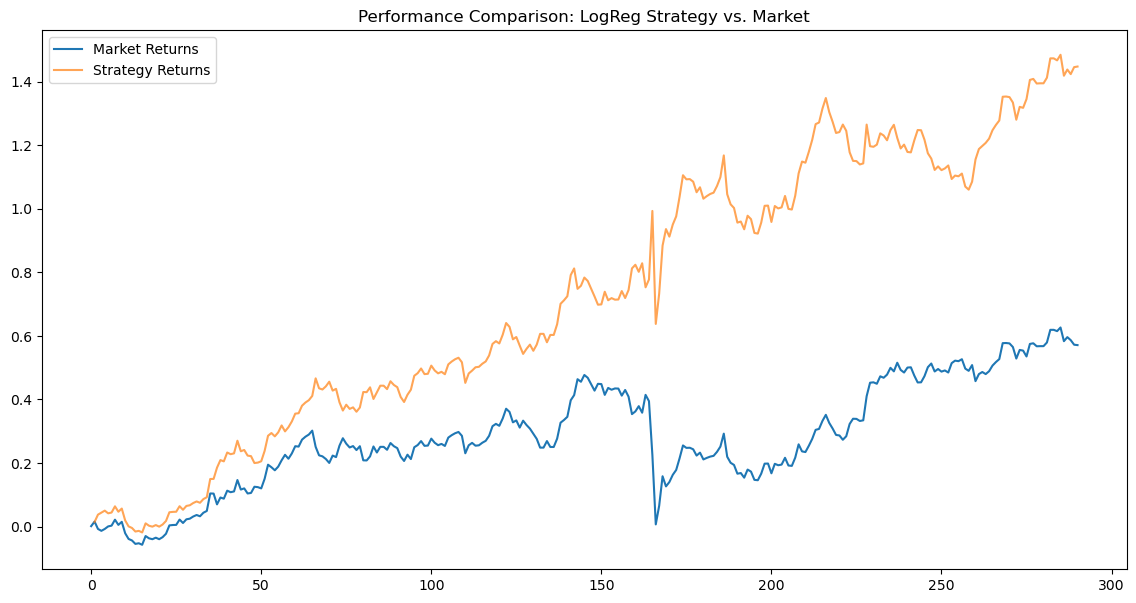

In [15]:
plt.figure(figsize=(14,7))
plt.plot(data['Cumulative_Market_Returns'], label='Market Returns')
plt.plot(data['Cumulative_Strategy_Returns'], label='Strategy Returns', alpha=0.7)
plt.legend(loc='upper left')
plt.title('Performance Comparison: LogReg Strategy vs. Market')
plt.show()